(labs:cor5)=
# Mathematical morphology

<hr>

## 📌 Commentaires pour les intervenants

**Mathematical morphology**

* 📣 Rappeler aux étudiants que dans un premier temps, ils doivent mettre en place toute une chaîne de traitement
  qui fournisse un nombre de piscine, même approximatif, à partir de l'image.
  Il faut éviter qu'ils cherchent à parfaire chaque étape, car le risque est de ne pas réussir à développer une méthode complète,
  faute de temps.
  Par ailleurs, le fait de développer une méthode complète permet d'avoir suffisamment de recul
  pour définir quelle étape est la moins performante, et donc celle qu'il faut améliorer en premier.
  
* L'exercice est assez long. Si des étudiants le terminent, alors ils reviennent sur les TP 1 et 2 pour les terminer également.

<hr>

### Objectives
* apply and compare basic operations (erosion, dilation, opening, closing)
* evaluate of the parameters of these operations
* use connected components to extract useful information

### First processings

In [23]:
from skimage.io import imread
from skimage.measure import regionprops
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing, disk, label
from matplotlib.pyplot import imshow, figure, hist, show, subplot, title, plot
from numpy import arange

The image is a satellite view of a small town in the Landes, France. It is an RGB image of resolution 50 cm.

In [24]:
img = imread('moliets.png')

Since the objects of interest are blue and no other object in the scene is of this color,
it may be interesting to deal with the blue band of the image.
Therefore, the pools are bright on the blue band, giving first discrimination between the pools and the rest.

In [25]:
blue = img[:,:,2]

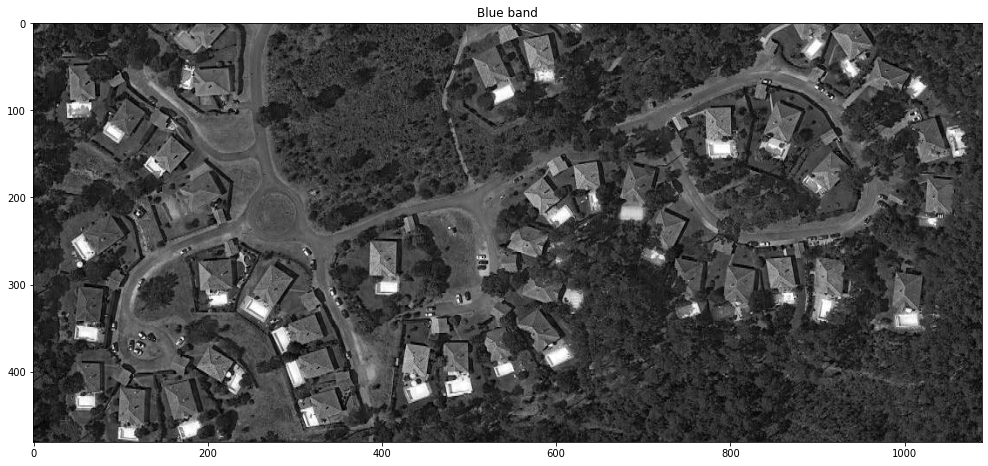

In [27]:
figure(figsize=(17,10))
imshow(blue, cmap='gray')
title('Blue band')
show()

The mathematical morphology operators described in the course work on binary images.
The blue band can be binarized by applying a threshold to separate the bright pixels from the others.
By looking at the histogram of the blue band and proceeding by trial and error,
we choose a threshold equals to 240.

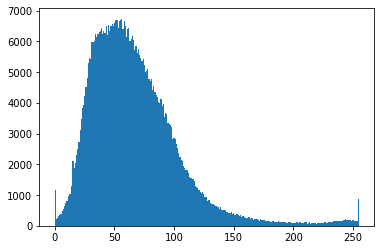

In [28]:
hist(blue.ravel(), bins=256)
show()

In [29]:
binarized = (blue > 240)

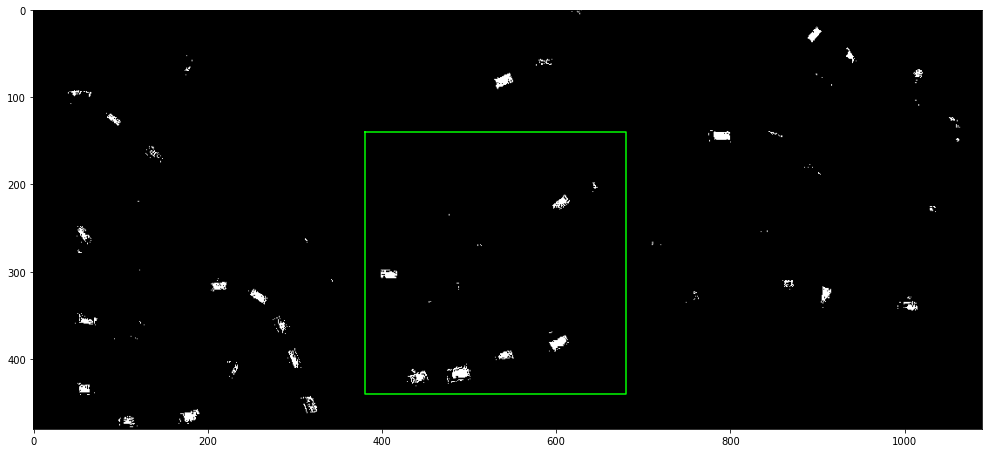

In [30]:
xmin, xmax, ymin, ymax = 380, 680, 140, 440
figure(figsize=(17,10))
imshow(binarized, cmap='gray')
plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color=[0,1,0])
show()

### Study of the different operators

In this part, the mathematical morphology operators are applied to the sub-image marked out by the green square on the image above.

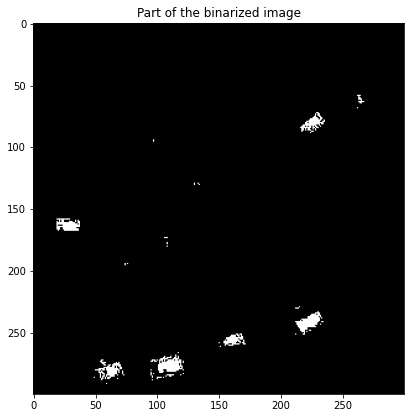

In [31]:
crop = binarized[ymin:ymax,xmin:xmax]
figure(figsize=(17,15))
subplot(2,2,1)
imshow(crop, cmap='gray')
title("Part of the binarized image")
show()

First of all, we choose as a structuring element a disk with a radius of 4 pixels.

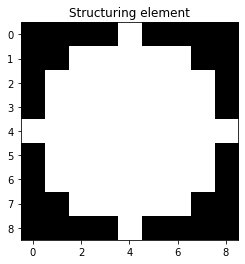

In [32]:
selem = disk(4)
imshow(selem, cmap='gray')
title("Structuring element")
show()

The four basic operators applied to the image produce the results below.

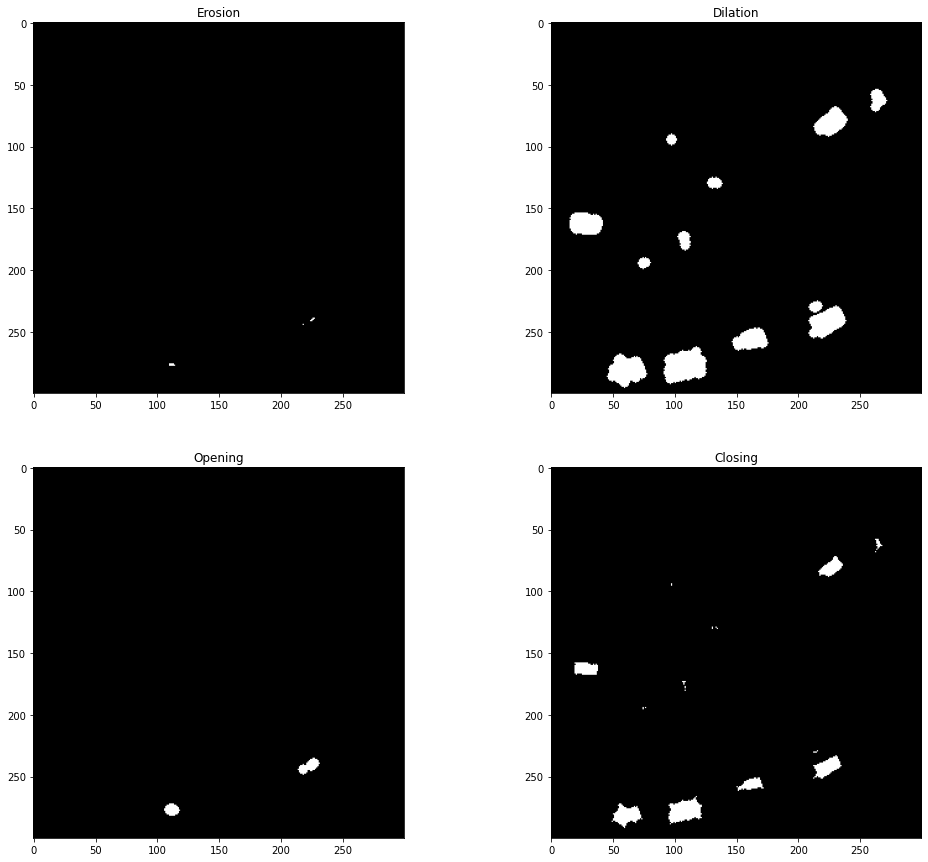

In [33]:
g_erosion = binary_erosion(crop, selem)
g_dilation = binary_dilation(crop, selem)
g_opening = binary_opening(crop, selem)
g_closing = binary_closing(crop, selem)

figure(figsize=(17,15))
subplot(2,2,1)
imshow(g_erosion, cmap='gray')
title('Erosion')
subplot(2,2,2)
imshow(g_dilation, cmap='gray')
title('Dilation')
subplot(2,2,3)
imshow(g_opening, cmap='gray')
title('Opening')
subplot(2,2,4)
imshow(g_closing, cmap='gray')
title('Closing')
show()

* Which operator(s) tend(s) to plug the holes?
* On the contrary, which operator(s) tend(s) to remove small objects?
* Which operator(s) preserve(s) (roughly) the shape of objects?

The same with a 10-pixel radius disk:

In [34]:
selem = disk(10)

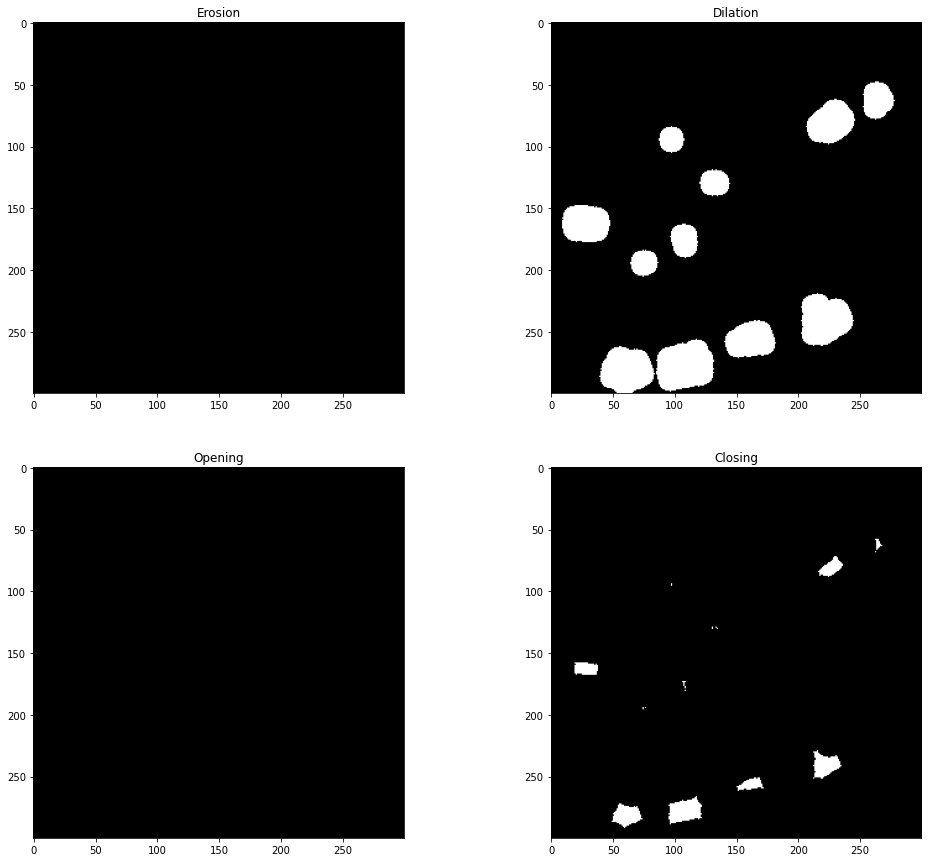

In [35]:
g_erosion = binary_erosion(crop, selem)
g_dilation = binary_dilation(crop, selem)
g_opening = binary_opening(crop, selem)
g_closing = binary_closing(crop, selem)

figure(figsize=(17,15))
subplot(2,2,1)
imshow(g_erosion, cmap='gray')
title('Erosion')
subplot(2,2,2)
imshow(g_dilation, cmap='gray')
title('Dilation')
subplot(2,2,3)
imshow(g_opening, cmap='gray')
title('Opening')
subplot(2,2,4)
imshow(g_closing, cmap='gray')
title('Closing')
show()

Try other structuring elements to observe their influence!

### Pool detection

In the following, we consider the result of a closing with a 10-pixel radius disk for structuring element.

The function `skimage.morphology.label` returns a labeling of the different connected components,
and the function `skimage.measure.regionprops` measure some geometric properties of the connected components,
such as their surface or their position.

In [36]:
# Élément structurant
selem = disk(10)

# Fermeture
img_closing = binary_closing(binarized, selem)

# Labellisation des composantes connexes
labels = label(img_closing, connectivity=2)

# Mesure des propriétés des composantes connexes
props = regionprops(labels)

# Nombre de composantes connexes
N = len(props)
print('Number of connected component (that is, detected pools): {}'.format(N))

Number of connected component (that is, detected pools): 69


The centroids of the connected components are represented in the image below by the red dots.

Of course, there are fewer pools than red dots, but a lot of connected components are actually
small groups of pixels that do not correspond to pools.

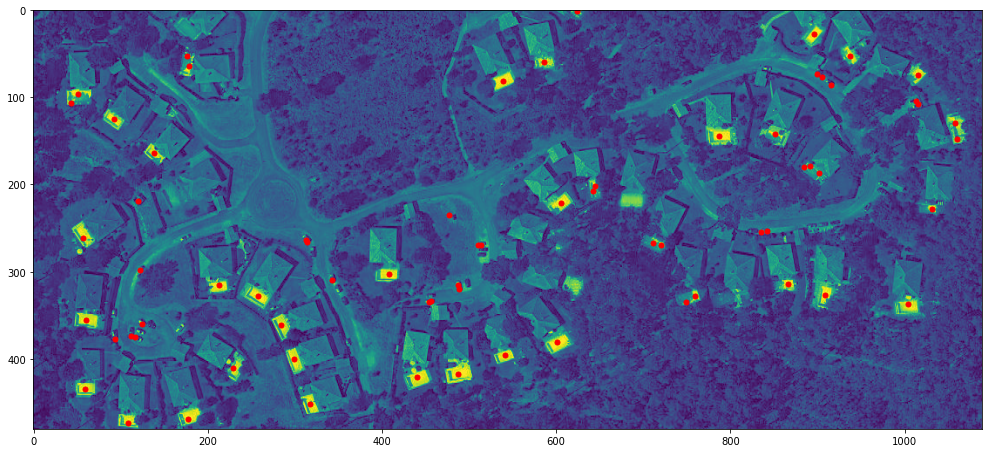

In [37]:
figure(figsize=(17,10))
imshow(blue)
for n in range(N):
    plot(props[n].centroid[1], props[n].centroid[0], 'r.', markersize=10)
show()


The result can be improved by considering only the connected components whose number of pixels is greater than a certain value.
So, we have chosen to consider as pools the connected components whose area is greater than 20 pixels.

Moreover, we know that a pixel represents an area of 0.5$\times$0.5 m<sup>2</sup>,
so it is easy to calculate the average area of the detected pools.

Number of detected pools: 36
Average area of the detected pools: 40.89 m²


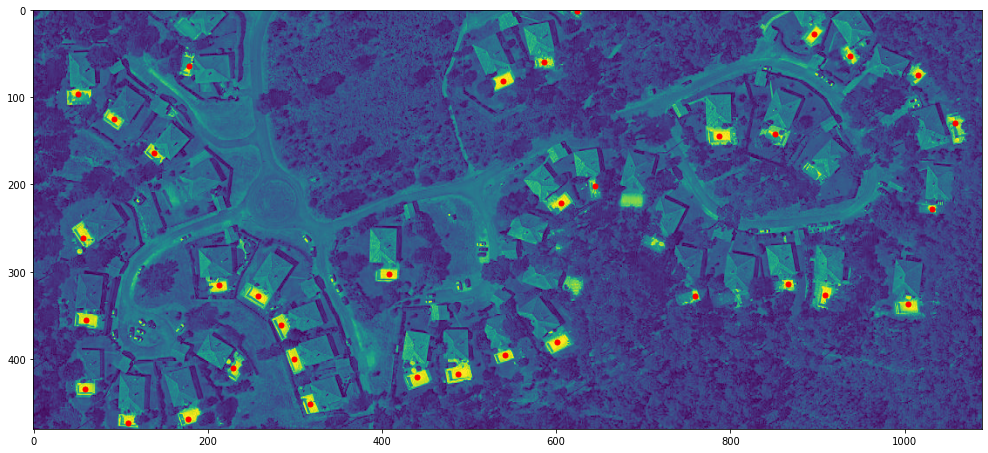

In [38]:
N = 0  # Nombre de piscines
A = 0  # Aire totale des piscines
figure(figsize=(17,10))
imshow(blue)
for r in props:
    if r.area > 20:
        N = N + 1
        A = A + r.area
        plot(r.centroid[1], r.centroid[0], 'r.', markersize=10)

print('Number of detected pools: {}'.format(N))
print('Average area of the detected pools: {:.2f} m²'.format(A/N*.5*.5))
show()

### Discussion

The method proposed in this notebook is simple but not robust: swimming pools shaded or partially hidden by a tree are not always detected. Conversely, some objects can be considered as swimming pools because they are very bright in the blue band and large.
Therefore, some improvements to improve the result are listed below:

* The geometry of the connected components can be considered because the swimming pools are not only blue objects with a sufficiently large area, but they also have a rectangular shape;
* we choose the threshold for binarization to work well on this image. But nothing guarantees that this value can be applied to another image: it may depend on the sensor resolution, the image brightness, the type of swimming pool, etc. In other words, the robustness of the threshold value has to be studied.
* the binarization of the image could take into account the binarization of the neighbouring pixels. This principle can be modelled using Markov fields.
* etc.

## Registration

> Dans le CM, la déformation rigide a pour parametre theta = {alpha, tx, ty}, alors que dans le TP j'utilise (x, y) et theta. Harmoniser les notations !

### Objectif

L'objectif de cet exercice est d'appréhender le problème du recalage par un premier exemple simple.

Les deux images à recaler sont :

In [16]:
import numpy as np
import skimage.io as io
import skimage.transform as tr
import matplotlib.pyplot as plt

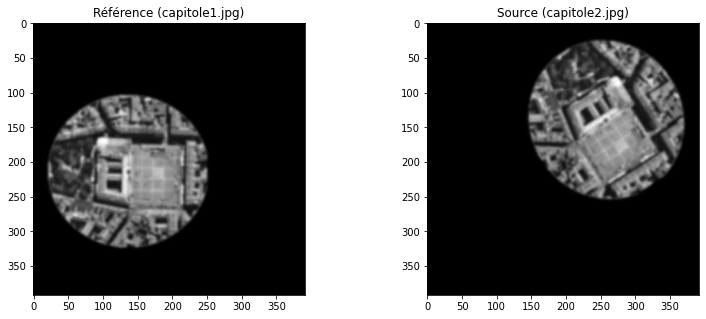

In [17]:
# Images

# http://www.cnes-csg.fr/web/CNES-en/9844-gp-first-pleiades-satellite-to-launch-16-december.php

f = io.imread("capitole1.jpg")
g = io.imread("capitole2.jpg")
(M, N) = f.shape

f = f/255
g = g/255

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(f, "gray")
plt.title("Référence (capitole1.jpg)")
plt.subplot(1,3,2)
plt.imshow(g, "gray")
plt.title("Source (capitole2.jpg)")
plt.show()

Pour recaler la source sur la référence, l'image doit subir une rotation et une translation : il s'agit donc d'une déformation rigide, appelée aussi euclidienne car elle préserve la distance euclidienne entre les pixels de l'image.
Cette déformation correspond à appliquer deux opérations :
* une rotation de l'image d'un angle $\theta$ est d'abord appliquée, autour du pixel $(0,0)$ (le coin en haut à gauche de l'image),
* une translation $(x,y)$ est ensuite effectuée, la translation s'effectuant suivant le nouveau repère de l'image (selon la rotation précédente).

La déformation rigide est donc définie par trois paramètres : une translation $(x,y)$ et une rotation $\theta$.
La fonction `skimage.transform.EuclideanTransform` permet de définir une telle déformation.
L'image est transformée selon cette déformation avec la fonction `skimage.transform.warp` :

```
transformation = transform.EuclideanTransform(translation=(x,y), rotation=t)
h = transform.warp(g, transformation)
```

Une transformation de rotation $\pi/3$ et de translation $(400,-100)$ donne ainsi :

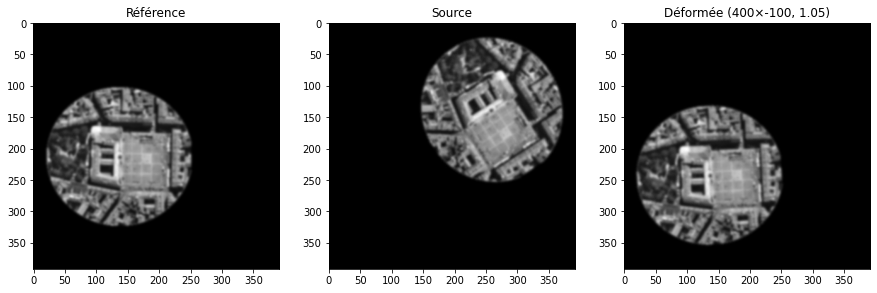

In [18]:
# Transformation test
# Attention, la rotation se fait autour du pixel (0,0)
# A Euclidean transformation, also called rigid transformation, preserves the Euclidean distance between pairs of points.
# It can be described as a rotation about the origin followed by a translation.
# Les axes sont subissent également la rotation, de sorte que la translation se fait suivant les axes tranformés.

x, y, t = 400, -100, np.pi/3
trans = tr.EuclideanTransform(translation=(x,y), rotation=t)
h = tr.warp(g, trans)

# Affichage
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(f, "gray")
plt.title("Référence")
plt.subplot(1,3,2)
plt.imshow(g, "gray")
plt.title("Source")
plt.subplot(1,3,3)
plt.imshow(h, "gray")
plt.title(f"Déformée ({x}×{y}, {t:.3})")
plt.show()

On peut comparer visuellement la différence entre la référence et l'image déformée (attention : vérifiez que les images ont la même dynamique !)...

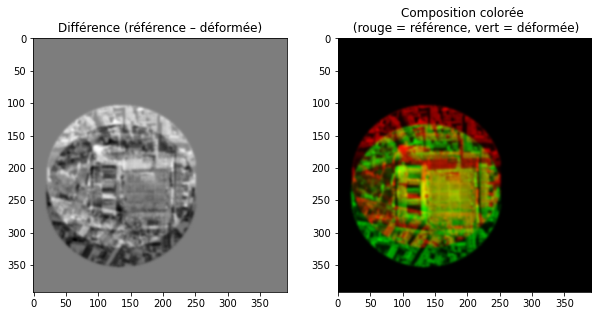

In [19]:
# EQM
eqm = np.linalg.norm(f-h)**2/(M*N)

# Composition colorée
c = np.zeros((M, N, 3))
c[:,:,0] = f
c[:,:,1] = h

# Affichage
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(f-h, "gray")
plt.title("Différence (référence – déformée)")
plt.subplot(1,2,2)
plt.imshow(c)
plt.title("Composition colorée \n (rouge = référence, vert = déformée)")
plt.show()

...ou en calculant l'EQM entre ces deux images :

In [20]:
print(f"EQM = {eqm:.3e}")

EQM = 2.537e-02


Sans autre valeur de comparaison, on ne peut pas dire, uniquement à partir de l'EQM, si le résultat est bon ou pas.
On voit cependant sur la différence entre les deux images que le recalage n'est pas encore très bon.

Il faut donc optimiser le critère de similarité (ici, l'EQM) en fonction des paramètres de la transformation ($x$, $y$, $\theta$).
Bien qu'il existe beaucoup de méthodes d'optimisation très efficaces, nous allons ici utiliser une méthode toute simple qui consiste à essayer toutes les valeurs de ces trois paramètres.
Pour chaque triplet $(x,y,\theta)$ il faudra donc appliquer la déformation et calculer l'EQM : si le nombre de combinaison est grand, le temps de calcul sera vite très long !

L'idée est donc de tester certains triplets $(x,y,\theta)$ autour de $(400,-100,\pi/3)$ testé précédemment.
Par exemple, on choisit de tester les valeurs selons les intervalles :

$$
x \in [300,500], \quad
y \in [-200,0], \quad
\theta \in [0,\pi].
$$

De plus, il faut commencer par un pas assez grossier, par exemple en allant de 10 en 10 pour les translations, et de $1$ en $1$ pour la rotation.
En fonction du résultat obtenu, on pourra ensuite affiner l'espace de recherche.

Le résultat obtenu de cette manière est le suivant :

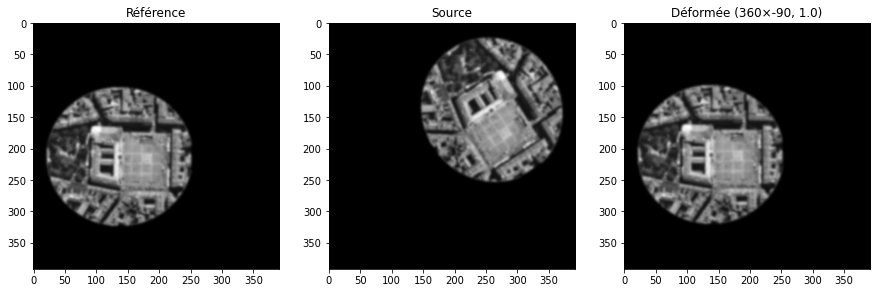

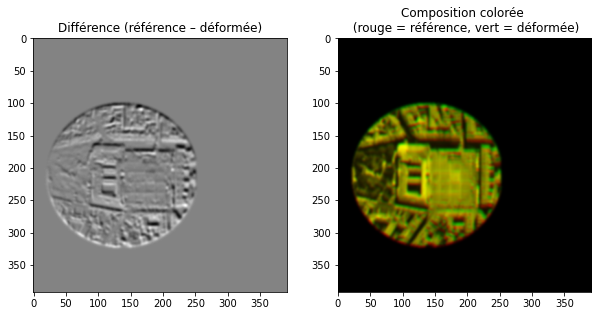

In [21]:
# Recherche de la meilleure transformation (sur une grille)

eqmmin = np.inf

for x in np.arange(300, 400, 10):
    for y in np.arange(-150, -50, 10):
        for t in np.arange(0, 2*np.pi, 1):
            
            # Transformation
            trans = tr.EuclideanTransform(translation=(x,y), rotation=t)
            h = tr.warp(g, trans)
            
            # EQM
            eqm = np.linalg.norm(f-h)**2/(M*N)
            if eqm < eqmmin:
                eqmmin = eqm
                xopt = x
                yopt = y
                topt = t

# Recalage estimé
trans = tr.EuclideanTransform(translation=(xopt,yopt), rotation=topt)
hopt = tr.warp(g, trans)

# Images
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(f, "gray")
plt.title("Référence")
plt.subplot(1,3,2)
plt.imshow(g, "gray")
plt.title("Source")
plt.subplot(1,3,3)
plt.imshow(hopt, "gray")
plt.title(f"Déformée ({xopt}×{yopt}, {topt:.3})")
plt.show()

# Différences
c[:,:,0] = f
c[:,:,1] = hopt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(f-hopt, "gray")
plt.title("Différence (référence – déformée)")
plt.subplot(1,2,2)
plt.imshow(c)
plt.title("Composition colorée \n (rouge = référence, vert = déformée)")
plt.show()

L'EQM est plus faible que celle obtenue ci-avant, ce qui montre que le recalage est meilleur :

In [22]:
# EQM
eqm = np.linalg.norm(f-hopt)**2/(M*N)
print(f"EQM = {eqm:.3e}")

EQM = 4.144e-03
